<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

# Effective computation in Biomechanics
## with [pyomeca](https://github.com/pyomeca/pyomeca)
Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))

<!--NAVIGATION-->
< [Reading and writing files](02.01-Reading-writing-files.ipynb) | [Contents](Index.ipynb) | [Other modules](02.03-Other-modules.ipynb) >

# Signal processing

In [1]:
from pathlib import Path
import numpy as np
from pyomeca import Analogs3d
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', context='talk')

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_PATH = Path("../data/trials")
filename = f'{DATA_PATH / "6kg_H2_1.c3d"}'

## Smoothing methods

In [3]:
raw = Analogs3d.from_c3d(filename, names=["delt_ant"])
WINDOW_SIZE = 100

In [4]:
def create_subplots(data, fmt=["k-", "r-"], labels=None):
    _, ax = plt.subplots(figsize=(12, 6))

    for i in range(len(data)):
        data[i].plot(fmt=fmt[i], label=labels[i], lw=3, ax=ax)
    plt.legend()
    sns.despine()

### Moving average

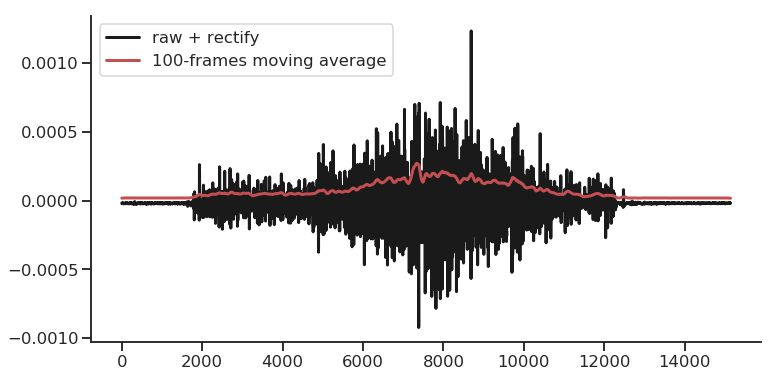

In [5]:
moving_average = raw.rectify().moving_average(window_size=WINDOW_SIZE)

create_subplots(
    data=[raw, moving_average],
    labels=["raw + rectify", f"{WINDOW_SIZE}-frames moving average"],
)

### Moving RMS

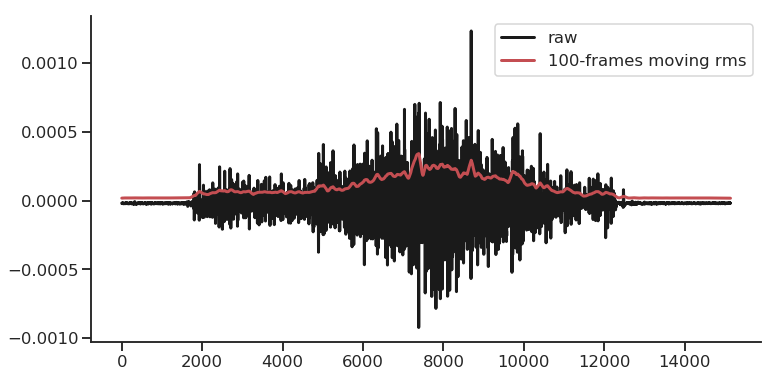

In [6]:
# we do not need to rectify
moving_rms = raw.moving_rms(window_size=100)

create_subplots(
    data=[raw, moving_rms], labels=["raw", f"{WINDOW_SIZE}-frames moving rms"]
)

### Moving median
sharper response to abrupt changes than the moving average

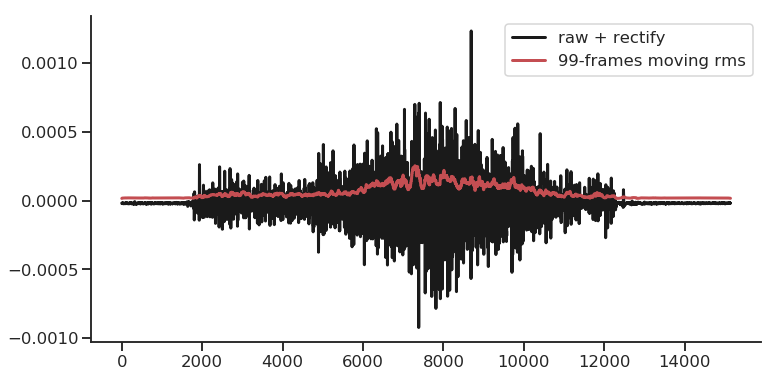

In [7]:
moving_median = raw.rectify().moving_median(window_size=99)

create_subplots(
    data=[raw, moving_median],
    labels=["raw + rectify", f"{WINDOW_SIZE-1}-frames moving rms"],
)

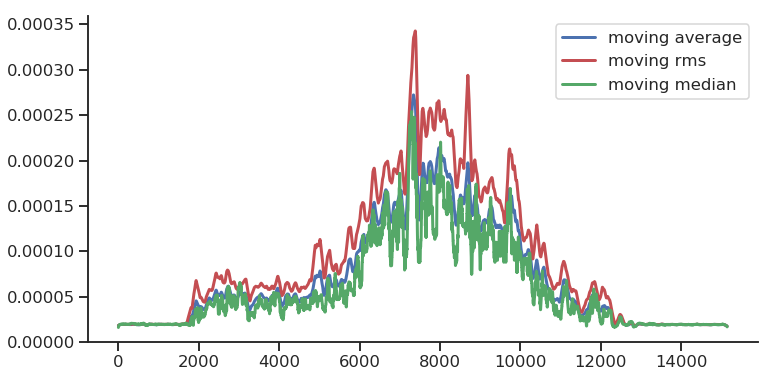

In [8]:
create_subplots(
    data=[moving_average, moving_rms, moving_median],
    fmt=["b-", "r-", "g-"],
    labels=["moving average", "moving rms", "moving median"],
)

## Math methods

- `matmul`: matrix product of two arrays

- `abs` or `rectify`: absolute values

- `rms`: root-mean-square values

- `center`: Center a signal (i.e., subtract the mean)

- `derivative`: numerical derivative

- `fft`: performs a discrete Fourier Transform and return amplitudes and frequencies

- `norm`: matrix norm

## Filtering methods

### Low-pass filter

In [9]:
# fake raw data
freq = 100
t = np.arange(0, 1, 0.01)
w = 2 * np.pi * 1
y = np.sin(w * t) + 0.1 * np.sin(10 * w * t)
y = Analogs3d(y.reshape(1, 1, -1))

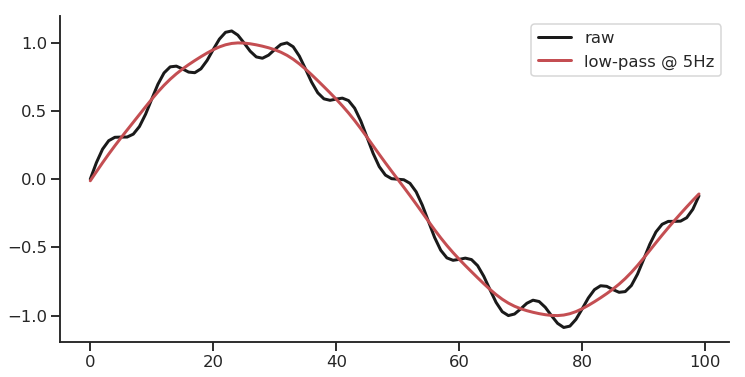

In [10]:
low_pass = y.low_pass(freq=freq, order=2, cutoff=5)

create_subplots(data=[y, low_pass], labels=["raw", "low-pass @ 5Hz"])

### Band-pass filter

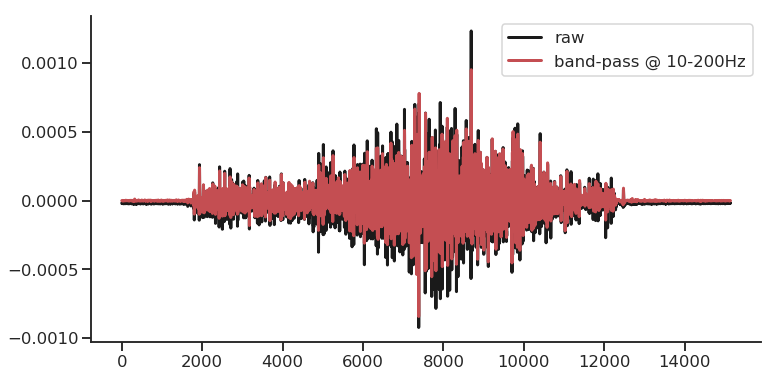

In [11]:
band_pass = raw.band_pass(freq=raw.get_rate, order=4, cutoff=[10, 200])

create_subplots(data=[raw, band_pass], labels=["raw", "band-pass @ 10-200Hz"])

### Band-stop filter

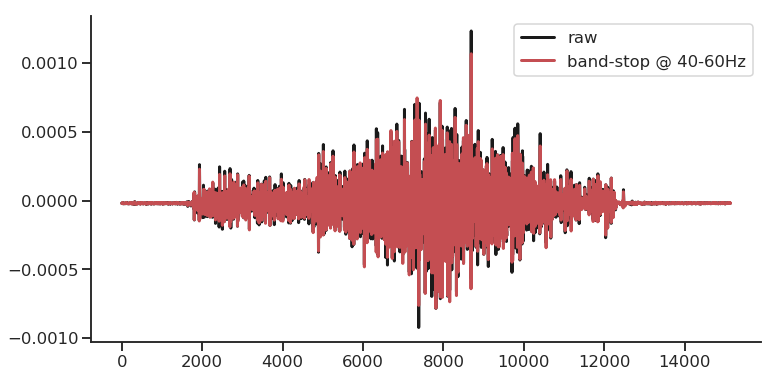

In [12]:
band_stop = raw.band_stop(freq=raw.get_rate, order=2, cutoff=[40, 60])

create_subplots(data=[raw, band_stop], labels=["raw", "band-stop @ 40-60Hz"])

### High-pass filter

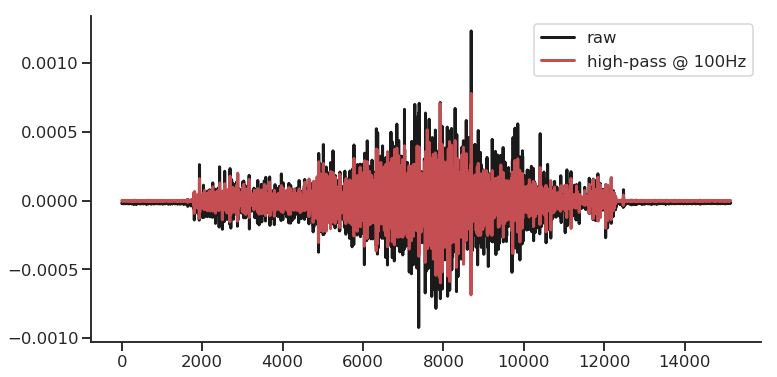

In [13]:
high_pass = raw.high_pass(freq=raw.get_rate, order=2, cutoff=100)

create_subplots(data=[raw, high_pass], labels=["raw", "high-pass @ 100Hz"])

## Utils methods

### FFT

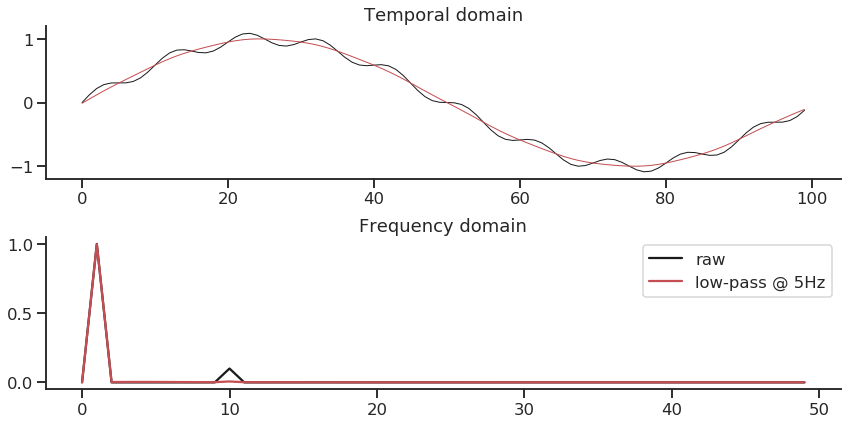

In [14]:
amp, freqs = y.fft(freq=freq)
amp_filtered, freqs_filtered = low_pass.fft(freq=freq)

_, ax = plt.subplots(2, 1, figsize=(12, 6))

y.plot(ax=ax[0], fmt="k-", label="raw")
low_pass.plot(ax=ax[0], fmt="r-", label="low-pass @ 5Hz")
ax[0].set_title("Temporal domain")

ax[1].plot(freqs, amp.squeeze(), "k-", label="raw")
ax[1].plot(freqs_filtered, amp_filtered.squeeze(), "r-", label="low-pass @ 5Hz")
ax[1].set_title("Frequency domain")

ax[1].legend()
plt.tight_layout()
sns.despine()

### Normalization

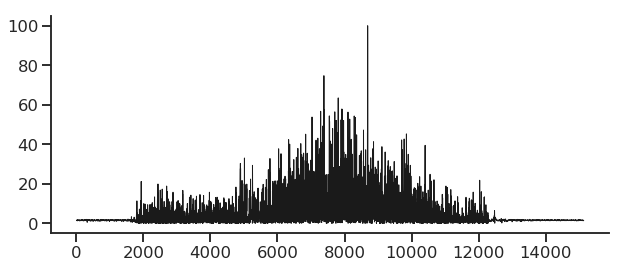

In [15]:
# if `ref` is not specified (MVC), take normalize with signal max
raw.rectify().normalization().plot()
sns.despine()

In [16]:
raw.normalization??

Signature: raw.normalization(ref=None, scale=100)
Source:   
    def normalization(self, ref=None, scale=100):
        """
        Normalize a signal against `ref` (x's max if empty) on a scale of `scale`

        Parameters
        ----------
        ref : np.ndarray
            reference value
        scale
            Scale on which to express x (100 by default)

        Returns
        -------
        FrameDependentNpArray
        """
        if not np.any(ref):
            ref = np.nanmax(self, axis=-1)
        # add one dimension
        ref = np.expand_dims(ref, axis=-1)
        return self / (ref / scale)
File:      ~/miniconda3/envs/tutorials/lib/python3.7/site-packages/pyomeca/frame_dependent.py
Type:      method


### Time normalization

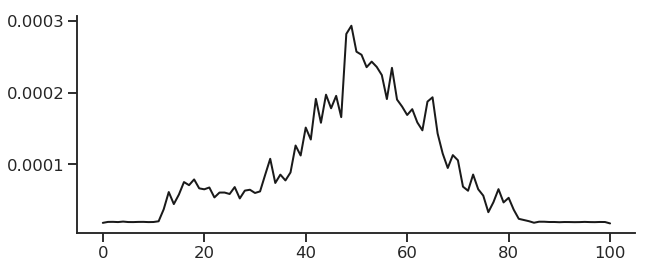

In [17]:
raw.moving_rms(100).time_normalization().plot(lw=2)
sns.despine()

### Fill values

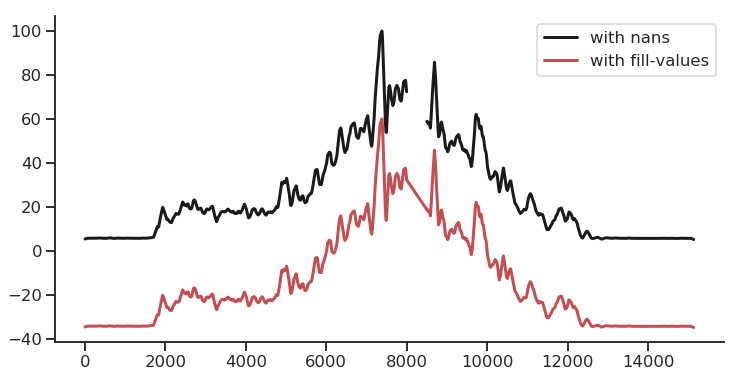

In [18]:
y_with_nans = moving_rms.normalization().copy()
y_with_nans[..., 8000:8500] = np.nan

create_subplots(
    data=[y_with_nans, y_with_nans.fill_values() - 40],
    labels=["with nans", "with fill-values"],
)

### Check for nans

In [19]:
y_with_nans.check_for_nans?

Signature: y_with_nans.check_for_nans(threshold_channel=10, threshold_consecutive=5)
Docstring:
1. Check if there is less than `threshold_channel`% of nans on each channel
2. Check if there is not more than `threshold_consecutive`% of the rate of consecutive nans

Parameters
----------
threshold_channel : int
    Threshold of tolerated nans on each channel
threshold_consecutive : int
    Threshold of tolerated consecutive nans on each channel
File:      ~/miniconda3/envs/tutorials/lib/python3.7/site-packages/pyomeca/frame_dependent.py
Type:      method


In [20]:
raw_with_nans = Analogs3d.from_c3d(
    "../data/io_examples/markers_analogs.c3d",
    names=["Delt_ant.EMG1", "Delt_med.EMG2", "Delt_post.EMG3"],
)
raw_with_nans[0, 0, 1000:1500] = np.nan
raw_with_nans[0, 2, 2000:3500] = np.nan

raw_with_nans.check_for_nans()
raw_with_nans.check_for_nans(threshold_channel=100)

ValueError: There is more than 10% ([12.93103448]) NaNs on the channel ([2])

### Detect onset

In [21]:
b = moving_rms.squeeze().copy()
b[8000:8500] = 0

# mean of the first second
mu = np.nanmean(b[..., : int(b.get_rate)])

onset = b.detect_onset(
    threshold=mu + mu * 0.1,    # mean of the first second + 10%
    above=int(b.get_rate) / 2,  # we want at least 1/2 second above the threshold
    below=int(b.get_rate) / 2,  # we accept point below threshold for 1/2 second
)

onset

array([[ 1731, 12538]])

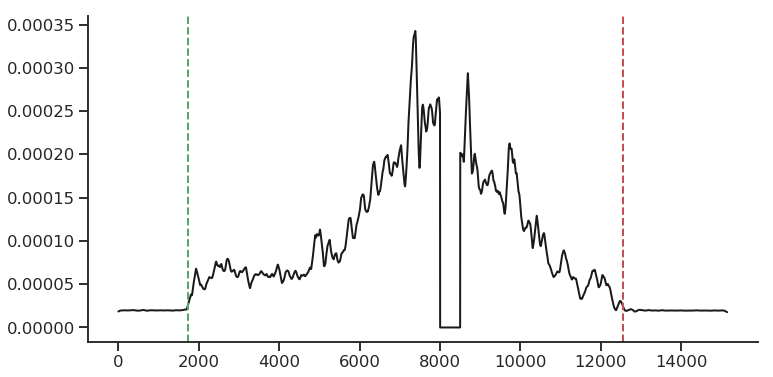

In [22]:
_, ax = plt.subplots(figsize=(12, 6))
ax.plot(b, "k-", lw=2)
for (inf, sup) in onset:
    ax.axvline(x=inf, color="g", lw=2, ls="--")
    ax.axvline(x=sup, color="r", lw=2, ls="--")
sns.despine()

### Detect outliers

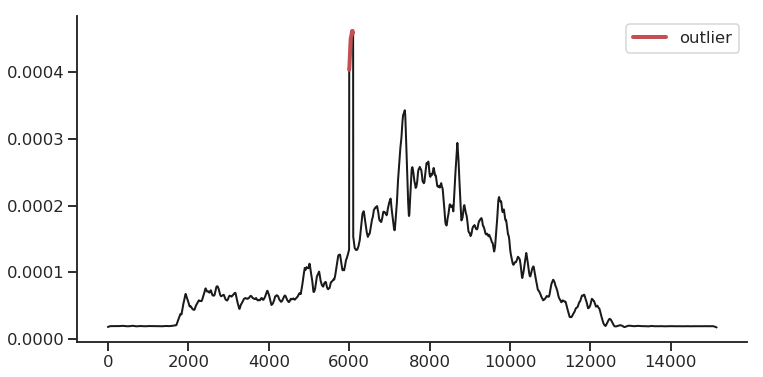

In [23]:
with_outliers = moving_rms.squeeze().copy()
with_outliers[6000:6100] = with_outliers[6000:6100] * 3

# detect outlier only on the onset
without_outliers = with_outliers.detect_outliers(onset_idx=onset, threshold=3)


_, ax = plt.subplots(figsize=(12, 6))

ax.plot(with_outliers, "k-", lw=2)
ax.plot(
    np.ma.masked_array(with_outliers.squeeze(), ~without_outliers.mask),
    "r-",
    label="outlier",
    lw=4,
)

plt.legend()
sns.despine()

### MVC

In [24]:
# MVC
from pyomeca import MVC

MVC?

Init signature: MVC(directories, channels, plot_trials=False, plot_mva=False, outlier=3, band_pass_cutoff=None, low_pass_cutoff=None, order=4)
Docstring:     
Return the Maximal Voluntary Contraction (MVA) array.
MVA is computed as follow:
        1. read the files
        2. process trial (band-pass, center, rectify, low-pass). You can modify the parameters of these steps in
            self.params
        3. detect onset
        4. remove data that are more than `outlier` standard deviations from the average of the onset
        5. concatenate all trials for a given muscle
        6. get mean of the highest sorted_values activation during `time` seconds

Parameters
----------
directories : list
    List of directories containing the trials to be processed
channels : list
    List (or list of lists) of string associated with each channel
plot_trials : bool
    If the plot of each trial must be displayed
plot_mva : bool
    If the plot of each mva must be displayed
outlier : int
    Mu

## Batch processing example

In [26]:
# the "ugly" version

# given by the MVC class
mvc = [0.0005562179366360516]

emgs = []
for ifile in DATA_PATH.glob("*.c3d"):
    c3d = Analogs3d.from_c3d(ifile)
    band_passed = c3d.band_pass(freq=c3d.get_rate, order=4, cutoff=[10, 425])
    centered = band_passed.center()
    rectified = centered.rectify()
    low_passed = rectified.low_pass(freq=c3d.get_rate, order=4, cutoff=5)
    normalized = low_passed.normalization(ref=mvc)
    time_normalized = normalized.time_normalization()

    emgs.append(
        time_normalized.update_misc({"filename": ifile.stem}).to_dataframe(
            add_metadata=['misc']
        )
    )

emgs = pd.concat(emgs)

In [28]:
# the "pythonic" version
emgs = pd.concat(
    [
        Analogs3d.from_c3d(ifile)
        .band_pass(freq=2000, order=4, cutoff=[10, 425])
        .center()
        .rectify()
        .low_pass(freq=2000, order=4, cutoff=5)
        .normalization(ref=mvc)
        .time_normalization()
        .update_misc({"filename": ifile.stem})
        .to_dataframe(add_metadata=['misc'])
        for ifile in DATA_PATH.glob("*.c3d")
    ]
)

emgs.head()

,delt_ant,filename
0,0.008846,12kg_H2_3
1,0.261197,12kg_H2_3
2,0.167504,12kg_H2_3
3,0.147101,12kg_H2_3
4,0.291319,12kg_H2_3


In [29]:
# save to csv for later use
emgs.reset_index().to_csv(DATA_PATH / 'emgs.csv', index=False)

<!--NAVIGATION-->
< [Reading and writing files](02.01-Reading-writing-files.ipynb) | [Contents](Index.ipynb) | [Other modules](02.03-Other-modules.ipynb) >